# Generate (message, image) recommendations for each user

In [1]:
import os
import openai
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

openai.api_key = os.environ['OPENAI_API_KEY']
np.set_printoptions(precision=3, suppress=True)
sns.set_theme(style='ticks', palette='Set2', font='monospace', font_scale=1.)


def get_embedding(text):
    """Compute embedding for a given text string."""
    result = openai.Embedding.create(input=text, model='text-embedding-ada-002')
    return np.array(result.data[0].embedding)


def center_embeddings(df):
    """Offset embeddings by it's center."""
    emb_center = df['embedding'].mean()
    df['embedding'] = df['embedding'].apply(lambda emb: emb - emb_center)


def softmax(x, temp=1.):
    """Compute row-wise softmax of a matrix x."""
    z = np.array(x)
    z -= z.max(axis=1, keepdims=True)
    z = np.exp(z / temp)
    z /= z.sum(axis=1, keepdims=True)
    return z


def visualize_embeddings():
    """Plot PCA projection of embeddings."""
    # compute embedding pca
    embs = np.array(messages.embedding.tolist() + images.embedding.tolist() + users.embedding.tolist())
    emb_pca = PCA(n_components=2).fit_transform(embs)
    messages_pca, images_pca, users_pca = np.split(emb_pca, [len(messages),-len(users)])

    # plot pca for messages, images, users
    fig, ax = plt.subplots(figsize=(6,4))
    ax.scatter(messages_pca[:,0], messages_pca[:,1], s=100)
    ax.scatter(images_pca[:,0], images_pca[:,1], s=100)
    ax.scatter(users_pca[:,0], users_pca[:,1], s=100)

    # add legend
    ax.scatter(-1, -1, s=125, color=sns.color_palette()[0], label='messages')
    ax.scatter(-1, -1, s=125, color=sns.color_palette()[1], label='images')
    ax.scatter(-1, -1, s=125, color=sns.color_palette()[2], label='users')
    ax.legend()
    
    # configure axes
    (x0, y0), (x1, y1) = 1.25*emb_pca.min(axis=0), 1.25*emb_pca.max(axis=0)
    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)    
    plt.tight_layout()
    plt.show()


def get_embedding_user(user, wl=.2, wd=.2):
    """Compute user embeddings accounting for likes and dislikes."""
    demo = f'{user.Age} year old {user.Race.lower()} {user.Gender.lower()}'
    emb = get_embedding(demo)

    # positively adjust embedding for likes
    for like in user.Likes.split(';'):
        emb += wl * get_embedding(like)
    
    # negatively adjust embedding for dislikes
    for dislike in user.Dislikes.split(';'):
        emb -= wd * get_embedding(dislike)
    
    return emb


def get_prefs(pref='norm', temp=.1, k=5):
    """Compute (user,message,image) proximity and return top k recommendations."""
    num_messages = len(messages)
    num_images = len(images)

    # compute preferences
    user_prefs = []
    for u, user_emb in enumerate(users.embedding):
        prefs = np.zeros((num_messages, num_images))
        for i, message_emb in enumerate(messages.embedding):
            for j, image_emb in enumerate(images.embedding):

                if pref == 'norm':
                    prefs[i][j] = -np.linalg.norm(user_emb - message_emb)\
                                - np.linalg.norm(user_emb - image_emb)\
                                - np.linalg.norm(message_emb - image_emb)
                elif pref == 'cos':
                    prefs[i][j] = cossim(user_emb, message_emb)\
                                + cossim(user_emb, image_emb)\
                                + cossim(message_emb, image_emb)
                elif pref == 'dot':
                    prefs[i][j] = np.dot(user_emb, message_emb)\
                                + np.dot(user_emb, image_emb)\
                                + np.dot(message_emb, image_emb)
                elif pref == 'ans':
                    prefs[i][j] = anssim(user_emb, message_emb)\
                                + anssim(user_emb, image_emb)\
                                + anssim(message_emb, image_emb)

        # normalize preferences
        probs = softmax(prefs.reshape(1,-1), temp=temp).reshape(num_messages, num_images)
        user_prefs.append(probs)

        # show k best recommendations for each person
        user = users.iloc[u]
        print(f'User {u}')
        print(f"Demographics: {user.Age} year old {user.Race.lower()} {user.Gender.lower()}")
        print(f"Likes: {', '.join(user.Likes.split(';'))}")
        print(f"Dislikes: {', '.join(user.Dislikes.split(';'))}\n")
        for ii, jj in zip(*np.unravel_index(np.argsort(probs, axis=None)[-1:-k-1:-1], probs.shape)):
            print(f'#{jj}/#{ii} ({100*probs[ii][jj]:2.0f}%): '\
                  + f'{images.loc[jj].Caption}\n{messages.loc[ii].Message}\n')
        print('================================================\n')

    return user_prefs


def cossim(emb1, emb2):
    """Compute cosine similarity between two embeddings."""
    return np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))


def anssim(emb1, emb2):
    """Compute AnS similarity between two embeddings."""
    cos = (1 - cossim(emb1, emb2)) / 2
    euc = np.linalg.norm(emb1 - emb2) / np.sqrt(len(emb1))
    dist = (cos/2 + cos*euc + euc/2) / 2
    return -dist


## Load and process content data

In [2]:
messages = pd.read_csv('./data/messages.csv')
messages['embedding'] = messages['Message'].apply(get_embedding)
messages

,Unnamed: 0,Message,embedding
0,0,Get up and groove! Dancing is your ticket to f...,"[-0.018359960988163948, -0.022691093385219574,..."
1,1,"Ditch the screen, hit the trail! Discover natu...","[0.004869637545198202, -0.014446374028921127, ..."
2,2,Give your eyes a break and let your body flow ...,"[-0.010539669543504715, -0.012567522935569286,..."
3,3,Hey! Why not leave the screen behind and hop o...,"[0.014402525499463081, -0.014138374477624893, ..."
4,4,Step away from the screen and let's stroll! Wa...,"[0.008818642236292362, -0.01577472686767578, 0..."
5,5,Dive into the pool and feel the freedom! Swap ...,"[0.00595455477014184, -0.0062295845709741116, ..."
6,6,Why not give your thumbs a break and start pum...,"[-0.01912401057779789, -0.028402743861079216, ..."
7,7,Hey! Ready to get moving? Put down the screen ...,"[-0.00423669908195734, -0.017857780680060387, ..."
8,8,Step away from the screen and let's roll! Expe...,"[0.005596579518169165, -0.017040908336639404, ..."
9,9,Step away from the screen and tee off into a w...,"[0.0009409974445588887, -0.021286888048052788,..."


In [3]:
images = pd.read_csv('./data/images.csv')
images['embedding'] = images['Caption'].apply(get_embedding)
images

,Unnamed: 0,Caption,embedding
0,0,"male, young, indian, playing guitar, smiling, ...","[-0.011060631833970547, -0.0067344726994633675..."
1,1,"woman, adult, white, sitting at a desk, writing","[-0.010568061843514442, 0.00019935572345275432..."
2,2,"woman, adult, white, preparing food, preparing...","[0.01242606621235609, -0.026520831510424614, -..."
3,3,"senior, white, male, holding a book, walking","[0.00892753154039383, -0.024854984134435654, -..."
4,4,"female, adult, white, reading a book with a be...","[-0.01509175542742014, -0.011503183282911777, ..."
5,5,"senior, white, male, sewing, working on a sewi...","[-0.02783632092177868, -0.03537313640117645, -..."
6,6,"female, young, adult, and smiling while leanin...","[-0.0006881997687742114, 0.007167846895754337,..."
7,7,"young, white, male, listening to music, headph...","[-0.006932427175343037, -0.01554698683321476, ..."
8,8,"male, adult, white, working on wood, making fu...","[0.0075802281498909, -0.01660185679793358, -0...."
9,9,"female, young, asian, taking a photo with a ca...","[-0.021007735282182693, 0.0020092143677175045,..."


In [4]:
users = pd.read_csv('./data/users.csv', dtype='str')
users['embedding'] = users.apply(get_embedding_user, axis=1)
users

,Gender,Age,Race,Likes,Dislikes,embedding
0,Male,35,White,sports;outdoors;active;physical,cerebral;domestic;sedentary;housekeeping,"[-0.006506923597771675, -0.0308910109102726, -..."
1,Female,56,Black,domestic;creative;crafts;indoors,sports;active;outdoors;physical,"[-0.006572670466266573, -0.00969018943142146, ..."
2,Male,42,Asian,games;sedentary;cerebral;indoors,active;sports;outdoors;creative,"[-0.002193531021475792, 0.002275305474177003, ..."
3,Female,21,Hispanic,active;sports;physical;outdoors,domestic;sedentary;housekeeping;crafts,"[-0.029628761915955693, 0.012848775717429815, ..."
4,Male,68,White,domestic;housekeeping;sedentary;indoors,active;outdoors;sports;physical,"[0.0007375652203336358, -0.010631428286433217,..."
5,Female,48,Black,creative;cerebral;crafts;sedentary,sports;outdoors;physical;domestic,"[-0.012294148618821055, -0.009731512307189405,..."
6,Male,32,Hispanic,active;sports;physical;games,creative;cerebral;housekeeping;indoors,"[-0.00656457645818591, 0.0018166843336075542, ..."
7,Female,66,Asian,housekeeping;indoors;domestic;sedentary,active;sports;outdoors;creative,"[0.003913411858957261, 0.004623391851782799, 0..."
8,Male,28,Black,outdoors;active;sports;physical,crafts;domestic;indoors;sedentary,"[-0.0011403120472095903, -0.021650410839356482..."
9,Female,64,White,cerebral;indoors;crafts;creative,outdoors;active;sports;physical,"[-0.008531209244392811, -0.007972783478908244,..."


## Visualize content embeddings

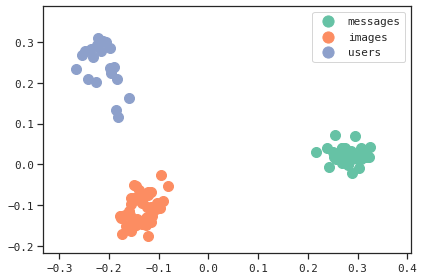

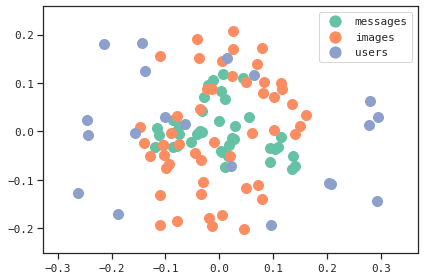

In [5]:
visualize_embeddings()
for df in [messages, images, users]:
    center_embeddings(df)
visualize_embeddings()

## Compute recommendations

In [6]:
prefs = get_prefs(pref='dot', temp=.01, k=5)

User 0
Demographics: 35 year old white male
Likes: sports, outdoors, active, physical
Dislikes: cerebral, domestic, sedentary, housekeeping

#22/#9 (58%): male, adult, black, golfing, teeing off
Step away from the screen and tee off into a world of fun and relaxation! Golfing boosts your mood, improves focus, and gets you outdoors enjoying nature. Let's swing into action!

#33/#1 (11%): young, white, male, backpack, hiking, mountain, forest, view
Ditch the screen, hit the trail! Discover nature's wonders, boost your mood, and energize your body with an invigorating hike.

#38/#3 ( 8%): male, adult, white, posing with a bike
Hey! Why not leave the screen behind and hop on your bike? Feel the wind in your hair, soak up the sunshine, and boost your mood while getting some exercise. Let's go biking and enjoy the great outdoors!

#16/#16 ( 6%): young, white, male, chess, playing, chess
Step away from the screen and dive into the captivating world of chess - sharpen your focus, boost problem